In [1]:
# Allows us to import packages that exist one level up in the file system
# See https://stackoverflow.com/questions/34478398
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path = [module_path] + sys.path

In [2]:
from tagnews.utils import load_data as ld
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.feature_extraction.text
import sklearn.multiclass
import sklearn.linear_model
% matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

In [3]:
df = ld.load_data()

/home/kevin/Documents/github/article-tagging/lib/tagnews/utils/load_data.py:185: RuntimeWarning: 1 location strings were not found in the bodytext.
  RuntimeWarning)


# Article Tags Exploration

In [4]:
print('# total articles       :', df.shape[0])
print('# tagged articles      :', df.loc[:, 'OEMC':'TASR'].any(1).sum())
print('# not relevant articles:', (~df['relevant']).sum())
print('# w/ no information    :', df.shape[0] - df.loc[:, 'OEMC':'TASR'].any(1).sum() - (~df['relevant']).sum())
print('# w/ location info     :', df['locations'].apply(bool).sum())

# this number should be 0, but it isn't...
print('\n# articles tagged but not relevant :', (~df['relevant'] & df.loc[:, 'OEMC':'TASR'].any(1)).sum())

# total articles       : 399934
# tagged articles      : 41754
# not relevant articles: 167268
# w/ no information    : 190912
# w/ location info     : 975

# articles tagged but not relevant : 2738


In [5]:
categories_df = ld.load_categories()
categories_df = categories_df.loc[:, ['abbreviation', 'category_name']]
categories_df.set_index('abbreviation', drop=True, inplace=True)

categories_df['counts'] = df.loc[:, 'OEMC':'TASR'].apply(sum, reduce=True)
categories_df.sort_values(by='counts')

,category_name,counts
abbreviation,,
ENVI,Environmental Crimes,55.0
TASR,Police Use of Taser,128.0
OEMC,Office of Emergency Management & Communications,134.0
REEN,Re-Entry,152.0
CPBD,Chicago Police Board,178.0
ILSC,Illinois State Court,196.0
CPUB,Cook County Public Defender's Office,232.0
IMMG,Immigration,257.0
IDOC,Illinois Department of Corrections,317.0


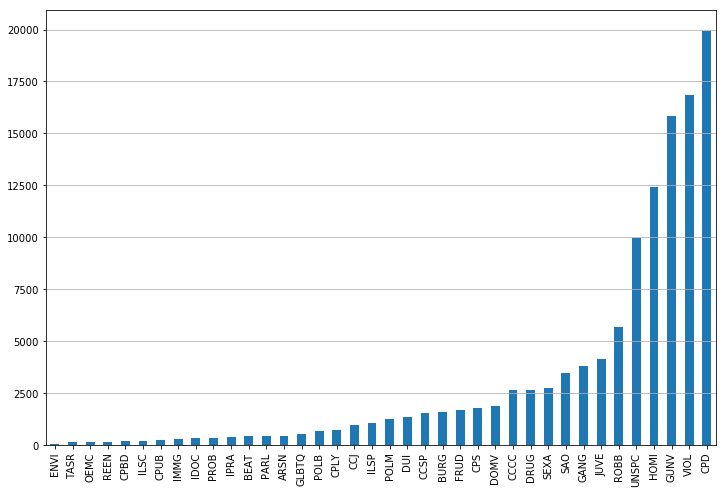

In [6]:
df.loc[:, 'OEMC':'TASR'].apply(sum, reduce=True).sort_values().plot(kind='bar')
g = plt.gca().yaxis.grid(True)

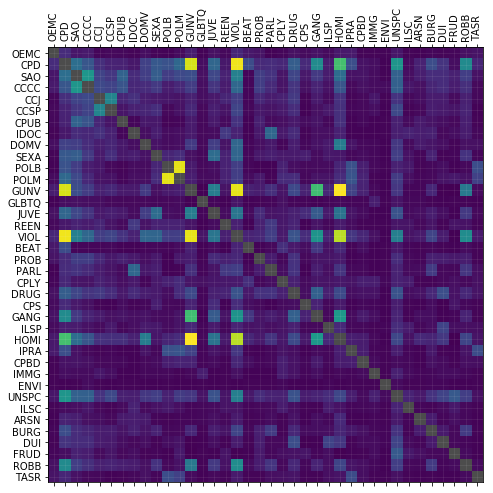

In [7]:
corrs = df.loc[:, 'OEMC':'TASR'].corr()
for i in range(corrs.shape[0]):
    corrs.iloc[i, i] = np.nan

cmap = matplotlib.cm.viridis
cmap.set_bad((.3, .3, .3),1.)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(np.ma.masked_invalid(corrs.values), cmap=cmap)

ax.grid(True, color=(.9, .9, .9), alpha=.1)

plt.xticks(range(len(corrs.columns)), corrs.columns, rotation=90);
plt.yticks(range(len(corrs.columns)), corrs.columns);

# Text Contents Exploration

In [8]:
# Print a random article just to see what they look like.
i = np.random.choice(df.shape[0])
print('ARTICLE ID:', df.index[i], '\n------------------')
print(df.iloc[i]['bodytext'])

ARTICLE ID: 23121 
------------------
By K.C. Johnson  Tribune reporter

2:39 p.m. CDT  ,  April 30, 2012

The Chicago Bulls received a surprise visitor Monday: [ Derrick Rose ][1] .

  
Less than 48 hours after ending his season by tearing the anterior cruciate
ligament in his left knee, the league's reigning most valuable player came to
the Berto Center to begin treatment and healing of another kind. Several who
spoke to him said Rose focused more on how his teammates are doing than his
own injury.

  
"We want him be around," coach Tom Thibodeau said. "As much time as he needs
is fine. I don't think he'll be able to travel with us. But he'll be around.
And he wants to be around. He's anxious to get around his teammates. That's
the way Derrick is. He doesn't look back. He looks ahead. That's a great way
to be."

  
Thibodeau said he doesn't know if Rose will attend Tuesday's Game 2. A
specific medical plan for when Rose undergoes surgery is still being
formulated.

  
"He's got to wa

## Some questions:

* How to handle articles that talk about more than one crime (i.e. a summary of weekend violence)?
* Would we want the scraper to keep any more information going forward? Author name, for example?
* Do we want to have manually-defined cleaning built around the format? I.e. specifically remove the links at the bottom that are result of RSS format? 